In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import decomposition
import math

import re
%matplotlib inline

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, header=0, sep=',', encoding='pt154')
    data = data.rename(index=str, columns={'client_id': '_ID_', 'open_acount_flg': '_VAL_'})
    return data

In [4]:
train = read_data('../data/dummy_encoding_all_city_train.csv')
test = read_data('../data/dummy_encoding_all_city_test.csv')

In [5]:
train.head()

,_ID_,age,credit_sum,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender=0,gender=1,...,living_region=78,living_region=79,living_region=80,living_region=81,living_region=82,living_region=83,living_region=84,living_region=85,living_region=86,living_region=87
0,1,48,60.0,0.770249,30000.0,1.0,1.0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,28,11.0,0.248514,43000.0,2.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,32,11.0,0.459589,23000.0,5.0,0.0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,27,12.0,0.362536,17000.0,2.0,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,45,17.0,0.421385,25000.0,1.0,0.0,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y = train.open_account_flg
del train['_ID_']
del train['open_account_flg']

In [7]:
client_ids = test._ID_
del test['_ID_']

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train, y, test_size=0.3)

In [9]:
X_test = test

In [10]:
print(X_train.shape, X_valid.shape, X_test.shape)

(119522, 187) (51224, 187) (91940, 187)


# Xgboost

### parameter information: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [11]:
def modelfit(alg, X_train, X_valid, y_train, y_valid, useTrainCV=True, cv_folds=5, early_stopping_rounds=25):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    pred_train = alg.predict_proba(X_train)[:, 1]
    pred_valid = alg.predict_proba(X_valid)[:, 1]
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, pred_train))
    print("AUC Score (Valid): %f" % metrics.roc_auc_score(y_valid, pred_valid))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)[:30]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
AUC Score (Train): 0.800367
AUC Score (Valid): 0.768191


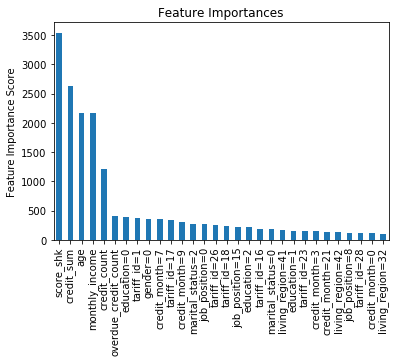

In [17]:
xgb1 = XGBClassifier(
 learning_rate =0.03,
 n_estimators=1000,
 max_depth=5,
#  min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=12,
 scale_pos_weight=1)

modelfit(xgb1, X_train, X_valid, y_train, y_valid)

In [16]:
pred_test = xgb1.predict_proba(X_test)[:, 1]
prediction = pd.DataFrame(data={'_ID_': client_ids, '_VAL_': pred_test}, index=test.index)
prediction.to_csv('../data/prediction.csv', index=False)
print(prediction.head())

     _ID_     _VAL_
0  170747  0.061416
1  170748  0.141096
2  170749  0.369601
3  170750  0.152010
4  170751  0.089827
